In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from distributed import Client
from tune import Space, Grid, Rand, RandInt, Choice
from tune_sklearn import sk_space, suggest_sk_models, suggest_sk_models_by_cv

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve

In [3]:
from fugue_notebook import setup
setup()

<IPython.core.display.Javascript object>

In [4]:
import warnings
warnings.filterwarnings('ignore')

## *Load Cleaned Data using DASK*

In [5]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [6]:
import dask.dataframe as dd
%time df = dd.read_csv('04_Pre_Processed.csv') 

Wall time: 19.8 ms


In [7]:
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_CITY_MARKET_ID,ORIGIN_CITY_NAME,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_CITY_MARKET_ID,DEST_CITY_NAME,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,CRS_ARR_TIME,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,DIV_AIRPORT_LANDINGS,CRS_DEP_TIME_MNT,CRS_DEP_TIME_MNT_norm,DEP_TIME_MNT,DEP_TIME_norm,FLIGHT_COUNT,PRIOR_ORIGIN_CITY_NAME,PRIOR_DELAY,PRIOR_DEP_MNT,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,BEGINING_OF_MONTH,MIDDLE_OF_MONTH,END_OF_MONTH,HOUR,MORNING,DAY,EVENING,NIGHT,WINTER,SPRING,SUMMER,AUTUMN,WEEKEND,WEEKDAY,DEPTIME_COS,DEPTIME_SIN
0,2019,1,1,1,2,7,0,1670,34082,252,12,7,33,34512,263,17,11,41,810,805,-5.0,0.0,0.0,-1.0,956,0.0,0.0,166.0,146.0,1127.0,0,490,2.139514,485,2.116212,1,220,0.0,0.000000,0,1,0,1,0,1,1,0,0,8,1,0,0,0,1,0,0,0,0,1,0.999985,0.005540
1,2019,1,1,1,2,7,0,1671,34512,263,17,11,41,34082,252,12,7,33,1041,1127,46.0,46.0,1.0,3.0,1422,0.0,0.0,161.0,153.0,1127.0,0,641,2.798834,687,2.997603,2,252,0.0,2.139514,0,1,0,1,0,1,1,0,0,11,1,0,0,0,1,0,0,0,0,1,0.999969,0.007848
2,2019,1,1,2,3,7,0,890,33195,299,12,7,33,31823,105,18,12,42,630,622,-8.0,0.0,0.0,-1.0,852,0.0,0.0,142.0,124.0,912.0,0,390,1.702879,382,1.666789,1,220,0.0,0.000000,0,0,0,0,0,0,1,0,0,6,0,0,0,1,1,0,0,0,0,1,0.999990,0.004364
3,2019,1,1,2,3,7,0,891,31823,105,18,12,42,33195,299,12,7,33,937,929,-8.0,0.0,0.0,-1.0,1155,0.0,0.0,138.0,126.0,912.0,0,577,2.519387,569,2.482731,2,298,0.0,1.702879,0,0,0,0,0,0,1,0,0,9,1,0,0,0,1,0,0,0,0,1,0.999979,0.006500
4,2019,1,1,2,3,7,0,1203,33195,299,12,7,33,30431,14,37,31,36,1314,1308,-6.0,0.0,0.0,-1.0,1448,0.0,0.0,94.0,73.0,519.0,0,794,3.466886,788,3.438299,3,105,0.0,2.519387,0,0,0,0,0,0,1,0,0,13,0,1,0,0,1,0,0,0,0,1,0.999959,0.009001


In [8]:
df.compute().shape

(1700781, 61)

In [9]:
df['DEP_DEL15'].compute().value_counts(normalize = True)

0.0    0.814923
1.0    0.185077
Name: DEP_DEL15, dtype: float64

### *Scalable Hyperparameter Tuning*

In [10]:
dft = df.compute().rename({'DEP_DEL15': 'label'}, axis='columns')

In [11]:
type(dft)

pandas.core.frame.DataFrame

In [12]:
dft = dft.sample(frac = 1)
dft.shape

(1700781, 61)

In [13]:
space = sum([
    sk_space(LogisticRegression, 
             random_state=0,
             C = Grid(0.001,0.01, 0.1, 1)),
    sk_space(RandomForestClassifier,
             random_state=0,
             criterion = Grid('entropy', 'gini'), 
             max_depth = Rand(5, 8, 10), 
             max_features = Grid('auto', 'sqrt'),
             min_samples_leaf = Rand(4, 6, 8),
             min_samples_split = Rand(5, 7,10),
             n_estimators = Grid(100, 200, 300),
             n_jobs = -1),
    sk_space(SVC(), 
             random_state=0,
             C = Grid(0.1, 1, 10, 100, 1000), 
             gamma = Rand(0.0001, 0.001, 0.01, 0.1, 1),
             kernel = 'rbf'),
    sk_space(GradientBoostingClassifier(),
             random_state=0,
             max_depth=8, min_samples_split=2, max_features='sqrt',
             learning_rate = Rand(0.001, 0.005, 0.01, 0.05, 0.1),
             n_estimators = Grid(100,300,500))
])

In [14]:
len(list(space))

24

In [15]:
%time result = suggest_sk_models_by_cv(space, train_df = dft, cv = 5, temp_path = r"C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\18_ML_Modeling\Capstone2", scoring="roc_auc")

#suggest_sk_models_by_cv(space, train_df, scoring, cv, temp_path, feature_prefix, label_col, 
#                        save_model, partition_keys, top_n, objective_runner, monitor, distributed, 
#                        execution_engine, execution_engine_conf)

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


Wall time: 15min 3s


In [16]:
for r in result:
    print(r.metric, r.trial.keys, r.trial.params)

0.985130808023397 [] {'C': 0.001, '__space__model': 'sklearn.linear_model._logistic.LogisticRegression', 'random_state': 0}


## *Modeling*

In [17]:
X = df.drop('DEP_DEL15', axis = 1)
y = df['DEP_DEL15']

### *Train-Test Split*

In [18]:
# Splitting the data
from dask_ml.model_selection import train_test_split
%time X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42, shuffle=True)

Wall time: 6.37 ms


### *Standardization*

In [19]:
# Standardize data before modeling
from dask_ml.preprocessing import StandardScaler
sc = StandardScaler()
%time X_train = sc.fit_transform(X_train)
%time X_test = sc.transform(X_test)

Wall time: 5.33 s
Wall time: 13 ms


In [20]:
%time X_train = X_train.persist()
%time X_test = X_test.persist()
%time y_train = y_train.persist()
%time y_test = y_test.persist()

Wall time: 4.53 s
Wall time: 4.57 s
Wall time: 3.26 s
Wall time: 3.45 s


In [21]:
type(X_train)

dask.dataframe.core.DataFrame

### *Logistic Regression*

In [22]:
# start a local Dask client
client1 = Client(n_workers=4, 
                threads_per_worker=2,
                memory_limit='128GB') 

In [23]:
client1

Client Scheduler: tcp://127.0.0.1:50341 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 67.66 GB


In [24]:
import joblib
from sklearn.linear_model import LogisticRegression
from dask_ml.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


lr = LogisticRegression(class_weight = 'balanced')
pca = PCA()
pipe = Pipeline(steps=[('pca', pca),
                       ('lr', lr)])

# Create the grid parameters 'lr__penalty': ['l1', 'l2'],
params = { 
    'pca__n_components': [2, 5, 15],
    'lr__C':[0.001,0.01, 0.1, 1]
}


lr_grid = GridSearchCV(pipe, params, n_jobs = -1)


with joblib.parallel_backend('dask'):
    %time _ = lr_grid.fit(X_train, y_train)

Wall time: 1min 12s


In [25]:
client1.close()

In [26]:
lr_grid.best_params_

{'lr__C': 0.001, 'pca__n_components': 15}

In [27]:
lr_grid_best = lr_grid.best_estimator_

In [28]:
# Calculating average precision score for X_train
apc_lr_train = average_precision_score(y_train, lr_grid_best.predict_proba(X_train)[:, 1])

# Calculating average precision score for X_test
apc_lr_test = average_precision_score(y_test, lr_grid_best.predict_proba(X_test)[:, 1])

print(f'Train Average Precision Score:{apc_lr_train}')
print(f'Test Average Precision Score:{apc_lr_test}')

Train Average Precision Score:0.9762077479953936
Test Average Precision Score:0.9766635075775008


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.98')

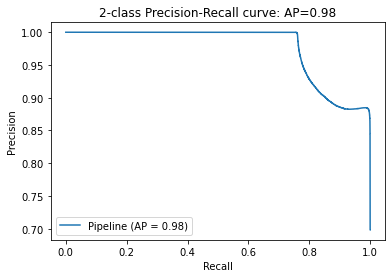

In [29]:
disp = plot_precision_recall_curve(lr_grid_best, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(apc_lr_test))

In [30]:
# Calculating average precision score for X_train
y_pred_lr_train = lr_grid_best.predict(X_train)
fpr_lr_train, tpr_lr_train, thresholds_lr_train = roc_curve(y_train, y_pred_lr_train)
auc_lr_train = auc(fpr_lr_train, tpr_lr_train)

# Calculating average precision score for X_test
y_pred_lr_test = lr_grid_best.predict(X_test)
fpr_lr_test, tpr_lr_test, thresholds_lr_test = roc_curve(y_test, y_pred_lr_test)
auc_lr_test = auc(fpr_lr_test, tpr_lr_test)                                                       

print(f'Train AUC Score:{auc_lr_train}')
print(f'Test AUC Score:{auc_lr_test}')

Train AUC Score:0.9815526852835141
Test AUC Score:0.981894144366036


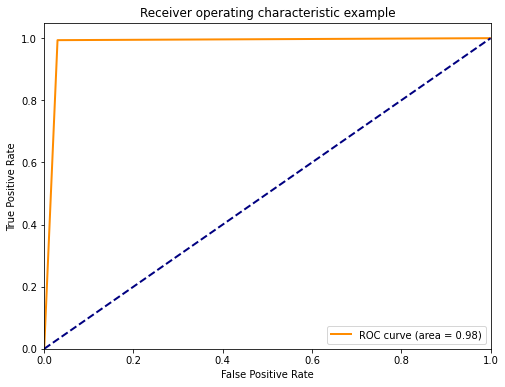

In [31]:
plt.figure(figsize = (8, 6))
lw = 2
plt.plot(fpr_lr_test, tpr_lr_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' %auc_lr_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

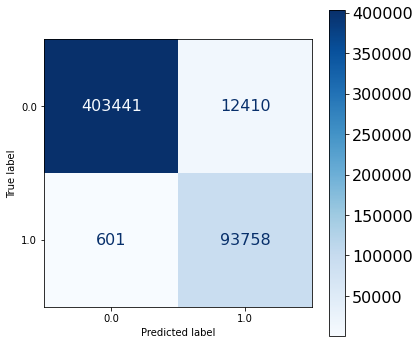

In [32]:
fig, ax = plt.subplots(figsize = (6,6))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(lr_grid_best, X_test, y_test, cmap=plt.cm.Blues, ax = ax, values_format = '') 
plt.show()

In [33]:
print(classification_report(y_test, y_pred_lr_test))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98    415851
         1.0       0.88      0.99      0.94     94359

    accuracy                           0.97    510210
   macro avg       0.94      0.98      0.96    510210
weighted avg       0.98      0.97      0.98    510210



In [34]:
roc_auc_score(y_test, lr_grid_best.predict_proba(X_test)[:, 1])

0.9946896871182194

### *RandomForestClassifier*

In [35]:
# start a local Dask client
client = Client(n_workers=4,
                threads_per_worker=2,
                memory_limit='128GB') 

In [36]:
client #client.get_versions(check=True)

Client Scheduler: tcp://127.0.0.1:50436 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 67.66 GB


In [37]:
import dask_ml.model_selection as dcv
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


rf = RandomForestClassifier(class_weight = 'balanced')
pca = PCA()
pipe = Pipeline(steps=[('pca', pca),
                       ('rf', rf)])

# Create the parameter grid based on the results of random search 'bootstrap': [True, False],
params = {
    'pca__n_components': [5, 10],
    'rf__max_depth': [5, 8],
    'rf__min_samples_leaf': [2, 5],
    'rf__min_samples_split': [2, 5],
    'rf__n_estimators': [100, 200, 300]}


rf_grid = dcv.GridSearchCV(pipe, params, cv = 3, n_jobs = -1)

import joblib
with joblib.parallel_backend('dask'):
    %time rf_grid.fit(X_train, y_train)

Wall time: 4h 46min 4s


In [38]:
client.close()

In [39]:
rf_grid.best_params_

{'pca__n_components': 10,
 'rf__max_depth': 8,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 300}

In [40]:
rf_grid_best = rf_grid.best_estimator_

In [41]:
# Calculating average precision score for X_train
apc_rf_train = average_precision_score(y_train, rf_grid_best.predict_proba(X_train)[:, 1])

# Calculating average precision score for X_test
apc_rf_test = average_precision_score(y_test, rf_grid_best.predict_proba(X_test)[:, 1])

print(f'Train Average Precision Score:{apc_rf_train}')
print(f'Test Average Precision Score:{apc_rf_test}')

Train Average Precision Score:0.9760825316106331
Test Average Precision Score:0.9756075484448355


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.98')

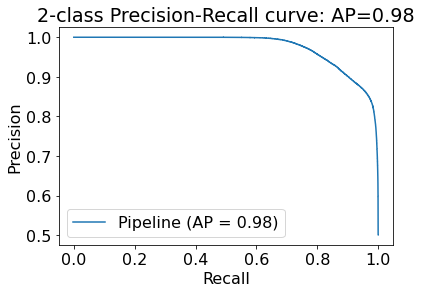

In [42]:
disp = plot_precision_recall_curve(rf_grid_best, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(apc_rf_test))

In [43]:
# Calculating AUC score for X_train
y_pred_rf_train = rf_grid_best.predict(X_train)
fpr_rf_train, tpr_rf_train, thresholds_rf_train = roc_curve(y_train, y_pred_rf_train)
auc_rf_train = auc(fpr_rf_train, tpr_rf_train)

# Calculating AUC score for X_test
y_pred_rf_test = rf_grid_best.predict(X_test)
fpr_rf_test, tpr_rf_test, thresholds_rf_test = roc_curve(y_test, y_pred_rf_test)
auc_rf_test = auc(fpr_rf_test, tpr_rf_test)                                                       

print(f'Train AUC Score:{auc_rf_train}')
print(f'Test AUC Score:{auc_rf_test}')

Train AUC Score:0.9615161517591804
Test AUC Score:0.9610676732612287


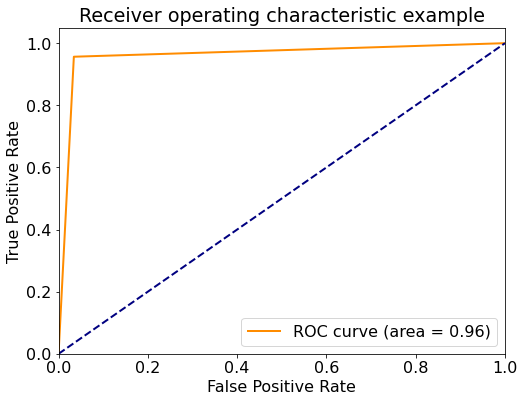

In [44]:
plt.figure(figsize = (8, 6))
lw = 2
plt.plot(fpr_rf_test, tpr_rf_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' %auc_rf_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

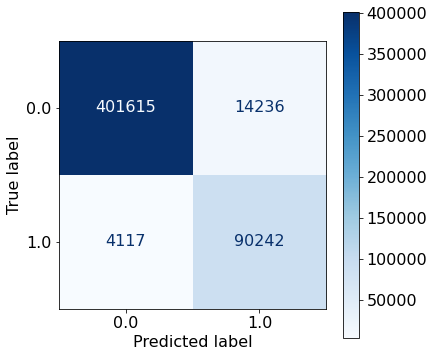

In [45]:
fig, ax = plt.subplots(figsize = (6,6))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(rf_grid_best, X_test, y_test, cmap=plt.cm.Blues, ax = ax, values_format = '') 
plt.show()

In [46]:
print(classification_report(y_test, y_pred_rf_test))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98    415851
         1.0       0.86      0.96      0.91     94359

    accuracy                           0.96    510210
   macro avg       0.93      0.96      0.94    510210
weighted avg       0.97      0.96      0.96    510210



In [47]:
roc_auc_score(y_test, rf_grid_best.predict_proba(X_test)[:, 1])

0.994194696211962

### *AdaBoostClassifier*

In [48]:
# start a local Dask client
client3 = Client(n_workers=4, 
                threads_per_worker=2,
                memory_limit='128GB') 

In [49]:
client3

Client Scheduler: tcp://127.0.0.1:52651 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 67.66 GB


In [50]:
import dask_ml.model_selection as dcv
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier()
pca = PCA()
pipe = Pipeline(steps=[('pca', pca),
                       ('ab', ab)])

# Create the parameter grid based on the results of random search 'bootstrap': [True, False],
params = {
    'pca__n_components': [5, 10],
    'ab__learning_rate': [0.5],
    'ab__n_estimators': [100, 300]}

ab_grid = dcv.GridSearchCV(pipe, params, cv = 3, n_jobs = -1)

import joblib
with joblib.parallel_backend('dask'):
    %time ab_grid.fit(X_train, y_train)

Wall time: 31min 56s


In [51]:
client3.close()

In [52]:
ab_grid.best_params_

{'ab__learning_rate': 0.5, 'ab__n_estimators': 300, 'pca__n_components': 5}

In [53]:
ab_grid_best = ab_grid.best_estimator_

In [54]:
# Calculating average precision score for X_train
apc_ab_train = average_precision_score(y_train, ab_grid_best.predict_proba(X_train)[:, 1])

# Calculating average precision score for X_test
apc_ab_test = average_precision_score(y_test, ab_grid_best.predict_proba(X_test)[:, 1])

print(f'Train Average Precision Score:{apc_ab_train}')
print(f'Test Average Precision Score:{apc_ab_test}')

Train Average Precision Score:0.971413799041554
Test Average Precision Score:0.9713627876276545


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.97')

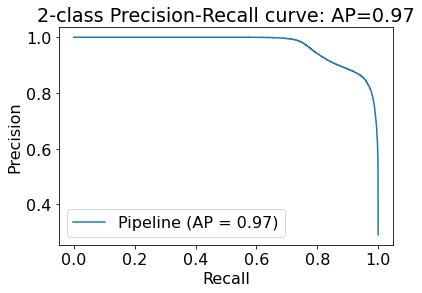

In [55]:
disp = plot_precision_recall_curve(ab_grid_best, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(apc_ab_test))

In [56]:
# Calculating average precision score for X_train
y_pred_ab_train = ab_grid_best.predict(X_train)
fpr_ab_train, tpr_ab_train, thresholds_ab_train = roc_curve(y_train, y_pred_ab_train)
auc_ab_train = auc(fpr_ab_train, tpr_ab_train)

# Calculating average precision score for X_test
y_pred_ab_test = ab_grid_best.predict(X_test)
fpr_ab_test, tpr_ab_test, thresholds_ab_test = roc_curve(y_test, y_pred_ab_test)
auc_ab_test = auc(fpr_ab_test, tpr_ab_test)                                                       

print(f'Train AUC Score:{auc_ab_train}')
print(f'Test AUC Score:{auc_ab_test}')

Train AUC Score:0.9170720174376057
Test AUC Score:0.9166597560093142


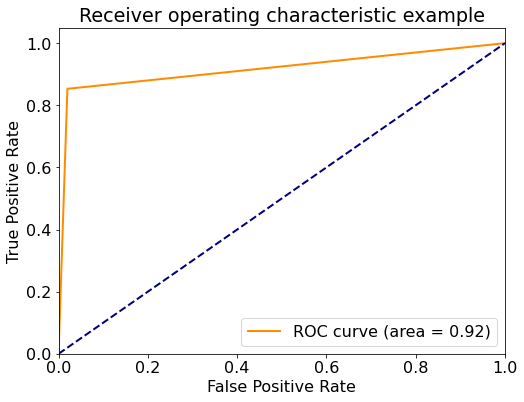

In [57]:
plt.figure(figsize = (8, 6))
lw = 2
plt.plot(fpr_ab_test, tpr_ab_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_ab_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

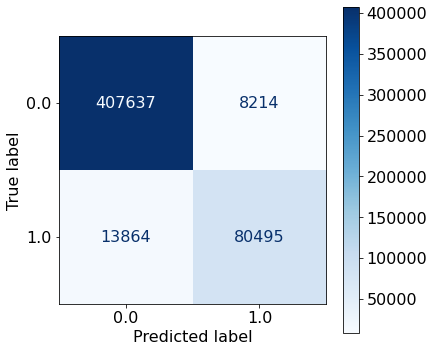

In [58]:
fig, ax = plt.subplots(figsize = (6,6))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(ab_grid_best, X_test, y_test, cmap=plt.cm.Blues, ax = ax, values_format = '') 
plt.show()

In [59]:
print(classification_report(y_test, y_pred_ab_test))

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97    415851
         1.0       0.91      0.85      0.88     94359

    accuracy                           0.96    510210
   macro avg       0.94      0.92      0.93    510210
weighted avg       0.96      0.96      0.96    510210



#### *Avergae Precision Score*

| Classifier | Train Score | Test Score |
| --- | --- | --- |
| BaseLine | 0.186 | 0.186 |
| Logistic Resgression | 0.976 | 0.977 |
| RandomForestClassifier | 0.976 | 0.976 |
| AdaBoostClassifier | 0.9714 | 0.9714 |

#### *AUC Score*

| Classifier | Train Score | Test Score |
| --- | --- | --- |
| Logistic Resgression | 0.9815 | 0.9819 |
| RandomForestClassifier | 0.9615 | 0.9611 |
| AdaBoostClassifier | 0.9170 | 0.9166 |

All the models used to train the data have outperformed the base line. The best suggested model by using Tune and Sask is is Logistic Regression.

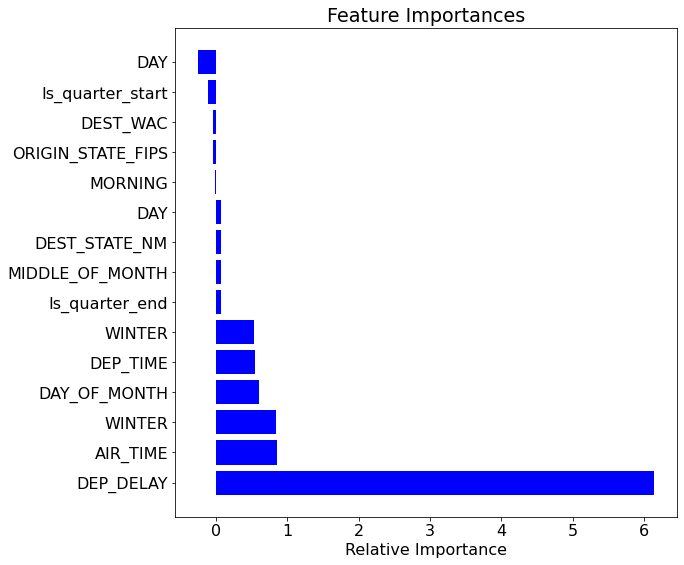

In [63]:
model = lr_grid_best.steps[0][1]
n_pcs= model.components_.shape[0]

initial_feature_names = X_train.columns

most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

zipped_feats = zip(most_important_names, lr_grid_best.steps[1][1].coef_.tolist()[0])
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)

features, importances = zip(*zipped_feats)

top_features = features[:15]
top_importances = importances[:15]

plt.figure(figsize = (9, 9))
plt.title('Feature Importances')
plt.barh(range(len(top_importances)), top_importances, color='b', align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel('Relative Importance')
plt.show()

Conclusions:

The dataset used for the project contains local flight data for the months January, February and March for the year 2019, does not take into considerations any weather conditions or natural calamities into account. 

Next Steps:

we plan to identify the significance of each feature by using stats models. Also, according to the Federal Aviation Administration, most of the delays in winter are due to surface winds, low ceiling and low visibility, whereas during summer the majority of delays is attributable to convective weather, low ceiling and associated low visibility (Federal Aviation Administration, 2017). It will be wise to include daily weather data, like wind, speed and precipitation rate, for each origin and destination location for each flight.